In [1]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [2]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [3]:
df = pd.read_sql("""
WITH tmp_data AS (SELECT
		code, year, month, day_month, count(trans_copy_code_id) as books
	FROM
		public.copytransaction, public.transactiontype, public.copy, public.student, public.date
	WHERE
	trans_location_code_id = 5 AND
	trans_type_code = 'ISS' AND
	--code = 199713183 AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

	GROUP BY code, year, month, day_month)

SELECT
code, year, month, count(day_month) as frecuency, sum(books) as total 
FROM tmp_data
GROUP BY code, year, month

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df

,code,year,month,frecuency,total
0,198224610,2000,9,1,2.0
1,198224610,2000,10,1,1.0
2,198224610,2000,11,2,9.0
3,198224610,2000,12,2,4.0
4,198224610,2001,2,1,2.0
...,...,...,...,...,...
780850,201880012,2017,10,1,1.0
780851,201880022,2017,11,3,3.0
780852,201880022,2017,12,2,2.0
780853,201880023,2018,3,1,1.0


In [5]:
# df["bajos_rendimientos"] = df["bajos_rendimientos"].astype(int)

df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
df.info()

# df = df.drop(columns=['trans_type_code'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780855 entries, 0 to 780854
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   code       780855 non-null  int32  
 1   year       780855 non-null  int32  
 2   month      780855 non-null  int32  
 3   frecuency  780855 non-null  int32  
 4   total      780855 non-null  float64
dtypes: float64(1), int32(4)
memory usage: 17.9 MB


In [6]:
#exploring the data

# checking null values
df.isnull().sum()

# visualize them
# df[df['bajos_rendimientos'].isnull()]

code         0
year         0
month        0
frecuency    0
total        0
dtype: int64

In [7]:
# investigate all the elements within each feature

for column in df:
    unique_values = np.unique(df[column])
    nr_values = len(unique_values)
    if nr_values < 100:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_values))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature code :56412
The number of values for feature year :22 -- [1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018]
The number of values for feature month :12 -- [ 1  2  3  4  5  6  7  8  9 10 11 12]
The number of values for feature frecuency :24 -- [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
The number of values for feature total :71 -- [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 59. 60. 61. 62. 63. 64. 65. 66. 67. 69. 71. 82. 91. 94.]


In [8]:
df.describe()

,code,year,month,frecuency,total
count,7.808550e+05,780855.000000,780855.000000,780855.000000,780855.000000
mean,2.005899e+08,2007.823364,6.596289,2.259366,3.748249
std,6.581526e+05,5.757443,3.432700,1.993171,3.779325
min,1.982246e+08,1997.000000,1.000000,1.000000,1.000000
25%,2.001240e+08,2003.000000,4.000000,1.000000,1.000000
50%,2.006323e+08,2008.000000,6.000000,1.000000,2.000000
75%,2.011289e+08,2013.000000,10.000000,3.000000,5.000000
max,2.018800e+08,2018.000000,12.000000,24.000000,94.000000


In [10]:
# Getting the columns we need

df.columns

Index(['code', 'year', 'month', 'frecuency', 'total'], dtype='object')

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
features = ['code', 'year', 'month', 'frecuency', 'total']

for f in features:
    sns.countplot(x = f, data = df, palette = 'Set3')# hue = 'Good Loan')
    plt.xticks(rotation=45)
    plt.show()
    

KeyboardInterrupt: 

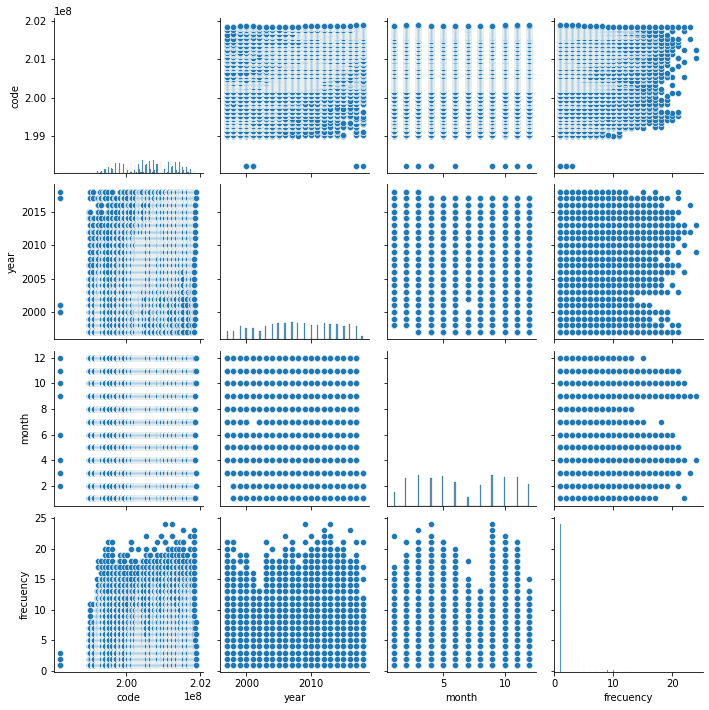

In [12]:
# Plot age, estrato, per_cancelados, per_matriculados
sns.pairplot(df[['code', 'year', 'month', 'frecuency']])

In [14]:
scaler = StandardScaler()
df[['frecuency_t', 'total_t']] = scaler.fit_transform(df[['frecuency', 'total']])

In [15]:
df

,code,year,month,frecuency,total,frecuency_t,total_t
0,198224610,2000,9,1,2.0,-0.631841,-0.462583
1,198224610,2000,10,1,1.0,-0.631841,-0.727180
2,198224610,2000,11,2,9.0,-0.130127,1.389601
3,198224610,2000,12,2,4.0,-0.130127,0.066613
4,198224610,2001,2,1,2.0,-0.631841,-0.462583
...,...,...,...,...,...,...,...
780850,201880012,2017,10,1,1.0,-0.631841,-0.727180
780851,201880022,2017,11,3,3.0,0.371586,-0.197985
780852,201880022,2017,12,2,2.0,-0.130127,-0.462583
780853,201880023,2018,3,1,1.0,-0.631841,-0.727180


In [16]:
import sklearn.cluster as cluster

kmeans = cluster.KMeans(n_clusters=3, init='k-means++', random_state=540)
kmeans = kmeans.fit(df[['frecuency_t', 'total_t']])

In [17]:
kmeans.cluster_centers_

array([[  7.9233664 ,  13.22937446],
       [ 11.59498736, 177.07413648],
       [ 12.29542302, 339.70319001],
       [ 10.80686804,  77.58353021],
       [ 12.98795181, 676.69477912]])

In [17]:
df['Clusters'] = kmeans.labels_

In [20]:
df.describe()

,code,year,month,frecuency,total,frecuency_t,total_t,Clusters
count,7.808550e+05,780855.000000,780855.000000,780855.000000,780855.000000,7.808550e+05,7.808550e+05,780855.000000
mean,2.005899e+08,2007.823364,6.596289,2.259366,3.748249,5.954744e-17,6.558954e-17,0.823356
std,6.581526e+05,5.757443,3.432700,1.993171,3.779325,1.000001e+00,1.000001e+00,0.491640
min,1.982246e+08,1997.000000,1.000000,1.000000,1.000000,-6.318407e-01,-7.271803e-01,0.000000
25%,2.001240e+08,2003.000000,4.000000,1.000000,1.000000,-6.318407e-01,-7.271803e-01,1.000000
50%,2.006323e+08,2008.000000,6.000000,1.000000,2.000000,-6.318407e-01,-4.625826e-01,1.000000
75%,2.011289e+08,2013.000000,10.000000,3.000000,5.000000,3.715862e-01,3.312104e-01,1.000000
max,2.018800e+08,2018.000000,12.000000,24.000000,94.000000,1.090757e+01,2.388040e+01,2.000000


In [19]:
df['Clusters'].value_counts()

1    567750
0    175519
2     37586
Name: Clusters, dtype: int64

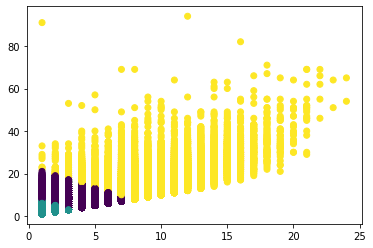

In [23]:
plt.scatter(x=df['frecuency'], y=df['total'], c=df['Clusters'])
plt.show()

<AxesSubplot:xlabel='per_matriculados', ylabel='count'>

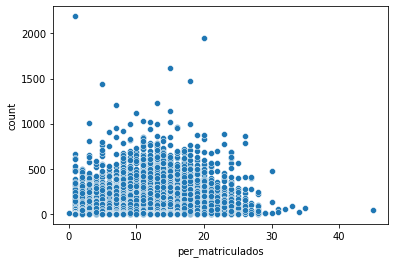

In [21]:
# Plot clusters on charts
sns.scatterplot(x='per_matriculados', y='count', data=df)